# Treatment Estimation with Deep End-to-end Causal Inference

This notebook demonstrates the functions `ate`, `cate`, `sample`, `_counterfactual` and `ite` and  that are supported on the DECI model.
 
### Dataset availability
To use the notebook, the CSuite datasets need to be available. Ensure that you have run the CSuite data generation script in `causica/data_generation/csuite/simulate.py` before attempting to load datasets.

For Microsoft internal users, the datasets will be automatically downloaded from storage.

In [1]:
import os
# Use this to set the notebook's woring directory to the top-level causica directory
os.chdir("../..")

In [2]:
import torch
import numpy as np
from causica.experiment.steps.step_func import load_data
from causica.models.deci.deci import DECI
import seaborn as sns
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt

In [3]:
dataset_config = {'dataset_format': 'causal_csv', 'use_predefined_dataset': True, 'test_fraction': 0.1, 
                  'val_fraction': 0.1, 'random_seed': 0, 'negative_sample': False}
### NOTE: setting 'var_dist_A_mode' = 'true' uses the true graph (for faster training)
###       replace with 'enco' or 'three' to learn the graph
model_config = {'tau_gumbel': 0.25, 'lambda_dag': 100.0, 'lambda_sparse': 5.0, 'spline_bins': 8, 
                'var_dist_A_mode': 'true', 'mode_f_sem': 'gnn_i', 'mode_adjacency': 'learn', 
                'norm_layers': True, 'res_connection': True, 'base_distribution_type': 'spline'}
training_params = {'learning_rate': 0.05, 'batch_size': 256, 'stardardize_data_mean': False, 
                   'stardardize_data_std': False, 'rho': 1.0, 'safety_rho': 10000000000000.0, 
                   'alpha': 0.0, 'safety_alpha': 10000000000000.0, 'tol_dag': 1e-04, 'progress_rate': 0.65, 
                   'max_steps_auglag': 6, 'max_auglag_inner_epochs': 1000, 'max_p_train_dropout': 0.6, 
                   'reconstruction_loss_factor': 1.0, 'anneal_entropy': 'noanneal'}

## Quickly training a DECI model

In [4]:
try:
    from evaluation_pipeline.aml_run_context import setup_run_context_in_aml
    run_context = setup_run_context_in_aml()
except ImportError:
    from common.experiment.run_context import RunContext
    run_context = RunContext()

Failure while loading azureml_run_type_providers. Failed to load entrypoint automl = azureml.train.automl.run:AutoMLRun._from_run_dto with exception (msrest 0.7.0 (/anaconda/envs/causica/lib/python3.8/site-packages), Requirement.parse('msrest<0.7.0,>=0.5.1'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.scriptrun = azureml.core.script_run:ScriptRun._from_run_dto with exception (msrest 0.7.0 (/anaconda/envs/causica/lib/python3.8/site-packages), Requirement.parse('msrest<0.7.0,>=0.5.1')).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core.run:PipelineRun._from_dto with exception (msrest 0.7.0 (/anaconda/envs/causica/lib/python3.8/site-packages), Requirement.parse('msrest<0.7.0,>=0.5.1'), {'azureml-core'}).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.ReusedStepRun = azureml.pipeline.core.run:StepRun._from_reused_dto with exc

To load the dataset, ensure that you have run the CSuite data generation script in `causica/data_generation/csuite/simulate.py`, ensure that the CSuite datasets have been created under `../data`, and ensure that the notebook's working directory has been set correctly.

Here, we use the true graph, but that is not necessary to use this functionality (it makes training quicker).

In [5]:
dataset = load_data("csuite_nonlin_simpson", "../data", 0, dataset_config, model_config, False)

/home/fosteradam/Causica/open_source/causica/datasets/csv_dataset_loader.py:133: UserWarning: Validation data file not found: ./data/csuite_nonlin_simpson/val.csv.
  warnings.warn(f"Validation data file not found: {val_data_path}.", UserWarning)


Minimum value of variable Column 0 inferred as -3.2742233276367183. This can be changed manually in the dataset's variables.json file
Max value of variable Column 0 inferred as 3.15141224861145. This can be changed manually in the dataset's variables.json file
Variable Column 0 inferred to be a queriable variable. This can be changed manually in the dataset's variables.json file by updating the "query" field.
Variable Column 0 inferred as not an active learning target variable. This can be changed manually in the dataset's variables.json file by updating the "target" field.
Variable Column 0 inferred as an always observed target variable. This can be changed manually in the dataset's variables.json file by updating the "always_observed" field.
Minimum value of variable Column 1 inferred as -1.5287634134292603. This can be changed manually in the dataset's variables.json file
Max value of variable Column 1 inferred as 2.87360954284668. This can be changed manually in the dataset's varia

In [6]:
train_data = pd.DataFrame(dataset._train_data, columns=["X0", "X1", "X2", "X3"])

In [7]:
train_data.head()

,X0,X1,X2,X3
0,-0.313854,-0.0862971,-2.20715,-1.1835
1,0.0557112,-0.248166,-0.817248,-0.760595
2,0.111356,-0.385469,-1.03544,-0.775432
3,0.749707,-0.736782,-1.54338,-1.01173
4,0.0290762,-0.454397,-1.75066,-1.08869


In [8]:
model = DECI("mymodel", dataset.variables, "mysavedir", "cuda", **model_config) #change cuda to cpu if GPU is not available

In [9]:
model.run_train(dataset, training_params, run_context=run_context)

/home/fosteradam/Causica/open_source/causica/preprocessing/data_processor.py:397: UserWarning: Data too low for continous variables [0 2 3]
  warnings.warn(
/home/fosteradam/Causica/open_source/causica/preprocessing/data_processor.py:402: UserWarning: Data too high for continous variables [0 2 3]
  warnings.warn(
/home/fosteradam/Causica/open_source/causica/utils/helper_functions.py:49: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729062494/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return tuple(torch.as_tensor(array, dtype=dtype, device=device) for array in arrays)


Auglag Step: 0
LR: 0.05
Inner Step: 500, loss: 2.24, log p(x|A): -1.79, dag: 0.00000000,                 log p(A)_sp: -0.01, log q(A): 0.000, H filled: 0.000, rec: 0.433
Inner Step: 1000, loss: 1.86, log p(x|A): -1.51, dag: 0.00000000,                 log p(A)_sp: -0.01, log q(A): 0.000, H filled: 0.000, rec: 0.346
Best model found at innner step 852, with Loss 1.35
Dag penalty after inner: 0.0000000000
Time taken for this step 17.271703481674194
[[[0. 1. 1. 0.]
  [0. 0. 1. 0.]
  [0. 0. 0. 1.]
  [0. 0. 0. 0.]]]
Not done inner optimization.
Dag penalty: 0.000000000000000
Rho: 1.00, alpha: 0.00
Auglag Step: 1
LR: 0.05
Inner Step: 500, loss: 1.47, log p(x|A): -1.21, dag: 0.00000000,                 log p(A)_sp: -0.01, log q(A): 0.000, H filled: 0.000, rec: 0.254
Reducing lr to 0.00500
Inner Step: 1000, loss: 1.42, log p(x|A): -1.16, dag: 0.00000000,                 log p(A)_sp: -0.01, log q(A): 0.000, H filled: 0.000, rec: 0.249
Best model found at innner step 1000, with Loss 1.19
Dag pen

With the trained model, we are now able to quickly get ATE, CATE, ITE and counterfactual estimates without additional retraining!

## Treatment effect estimation

For treatment effect estimation with non-binary variables, we need to select the "treatment" `B` and "reference" `A` values that we are using. We select `mean + std` and `mean - std` as the values we are considering.

In [10]:
treatment_values = train_data.mean(0) + train_data.std(0)
reference_values = train_data.mean(0) - train_data.std(0)

### Average treatment effect (ATE)

In [11]:
ates = []
for variable in range(treatment_values.shape[0]):
    intervention_idxs = torch.tensor([variable])
    intervention_value = torch.tensor([treatment_values[variable]])
    reference_value = torch.tensor([reference_values[variable]])
    print(f"Computing the ATE between X{variable}={treatment_values[variable]} and X{variable}={reference_values[variable]}")
    # This estimate uses 200k samples for accuracy. You can get away with fewer if necessary
    ate, _ = model.cate(intervention_idxs, intervention_value, reference_value, Ngraphs=1000, Nsamples_per_graph=200)
    print(ate)
    ates.append(ate)

Computing the ATE between X0=0.9882734280299655 and X0=-0.9714331856451489
[ 1.96  -1.441  1.259  0.526]
Computing the ATE between X1=0.6042951007907429 and X1=-0.8248794225513154
[-0.002  1.429  1.484  0.708]
Computing the ATE between X2=-0.0874461591519049 and X2=-2.2234084444962807
[ 9.615e-04 -3.557e-04  2.136e+00  8.917e-01]
Computing the ATE between X3=-0.29498196284004263 and X3=-1.3015321400845723
[ 0.005 -0.002  0.005  1.007]


Sanity check: `X3` is not a directed parent of any node, so the ATE should be 0. `X2` is downstream of `X0` and `X1`, so these ATEs should also be 0.

Note: the treatment effect of a variable upon itself (e.g. `X0` on `X0`) is simply the difference between the treatment value and the reference value.

In [12]:
ate_matrix = np.stack(ates)
print(ate_matrix)

[[ 1.960e+00 -1.441e+00  1.259e+00  5.261e-01]
 [-2.277e-03  1.429e+00  1.484e+00  7.083e-01]
 [ 9.615e-04 -3.557e-04  2.136e+00  8.917e-01]
 [ 4.524e-03 -2.425e-03  4.883e-03  1.007e+00]]


### Conditional average treatment effect (CATE)
Suppose we want to compute the treatment effet of `X1` on `X2`, but conditional for some fixed value of `X0`. For this, we use the `cate` method. The implementation of CATE involves fitting an auxiliary model, so it will be slower than ATE and counterfactual calculation.
*Note 1*: there may be some variance in this estimate.
*Note 2*: there are some restrictions on the graph for this method. Check the DECI paper for more info.

In [13]:
# The variable and value to condition on
conditioning_idxs = torch.tensor([0])
conditioning_values = torch.tensor([treatment_values[0]])
# The intervention variable, intervention value and reference value, same as for ATE
intervention_idxs = torch.tensor([1])
intervention_value = torch.tensor([treatment_values[1]])
reference_value = torch.tensor([reference_values[1]])
# The variables to compute the effect upon (this has to be length 1)
effect_idxs = torch.tensor([2])
# Set the parameters of the auxiliary CATE model
model.cate_rff_n_features = 100
cate_estimate, _ = model.cate(intervention_idxs, intervention_value, reference_value, effect_idxs, conditioning_idxs,
                              conditioning_values, Ngraphs=1000, Nsamples_per_graph=20)
print(cate_estimate)

[1.356]


### Sample
Sample is the underlying method used for both ATE and CATE calculation. For ATE estimation, we simply take the mean over multiple samples. For CATE, we fix an auxiliary regression model to the samples. Sample can be computed under any interventional distribution.

In [14]:
%matplotlib inline

In [15]:
samples = model.sample(200000, intervention_idxs=torch.tensor([1]), intervention_values=torch.tensor([treatment_values[1]]),
                       samples_per_graph=200)

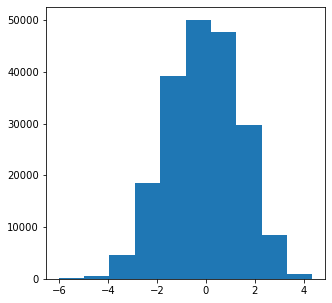

In [16]:
plt.figure(figsize=(5, 5))
plt.hist(samples[:, 2].cpu().numpy())
plt.show()

In [17]:
# Take samples under a different intervention
samples2 = model.sample(200000, intervention_idxs=torch.tensor([1]), intervention_values=torch.tensor([reference_values[1]]),
                        samples_per_graph=200)

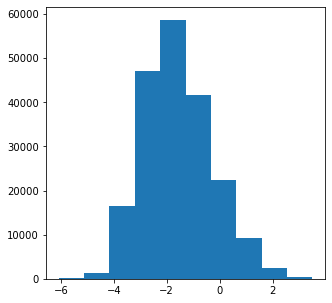

In [18]:
plt.figure(figsize=(5, 5))
plt.hist(samples2[:, 2].cpu().numpy())
plt.show()

ATE is estimated by taking the difference of the average of the two sets of samples.

### Counterfactual estimation

In [19]:
graph = model._get_adj_matrix_tensor(round=True, samples=1, most_likely_graph=True)
factual_samples = train_data.values.astype('float32')
counterfactual_samples = model._counterfactual(factual_samples, graph, 
                                               intervention_idxs=torch.tensor([1]),
                                               intervention_values=torch.tensor([reference_values[1]])
                                              ).detach().cpu().numpy()
counterfactual_data = pd.DataFrame(counterfactual_samples, columns=["X0", "X1", "X2", "X3"])

In [20]:
train_data.head()

,X0,X1,X2,X3
0,-0.313854,-0.0862971,-2.20715,-1.1835
1,0.0557112,-0.248166,-0.817248,-0.760595
2,0.111356,-0.385469,-1.03544,-0.775432
3,0.749707,-0.736782,-1.54338,-1.01173
4,0.0290762,-0.454397,-1.75066,-1.08869


In [21]:
counterfactual_data.head()

,X0,X1,X2,X3
0,-0.313854,-0.824879,-2.904177,-0.954822
1,0.055711,-0.824879,-1.268570,-0.528514
2,0.111356,-0.824879,-1.292711,-0.628512
3,0.749707,-0.824879,-1.585754,-0.990060
4,0.029076,-0.824879,-1.901278,-1.020412


Observations:
 - no change to column X0: this makes sense because X0 is upstream of the variable we are intervening on, X1
 - X1 is set to the intervention value
 - X2 and X3 change to their counterfactual values

### Individual treatment effect (ITE)
Counterfactuals are the basis for computing ITEs. ITE does not involve resampling the noise. Unless there is significant graph uncertainty, it makes sense to use just the most likely graph, which is very fast

In [22]:
ite, _ = model.ite(factual_samples, intervention_idxs=torch.tensor([1]),
                   intervention_values=torch.tensor([treatment_values[1]]),
                   reference_values=torch.tensor([reference_values[1]]),
                   Ngraphs=1, most_likely_graph=True)
ite_df = pd.DataFrame(ite, columns=["X0", "X1", "X2", "X3"])

In [23]:
ite_df.head()

,X0,X1,X2,X3
0,0.0,1.429174,1.499376,0.465578
1,0.0,1.429174,1.682924,0.832765
2,0.0,1.429174,1.704715,0.828641
3,0.0,1.429174,1.764969,0.797604
4,0.0,1.429174,1.672215,0.715442


The average ITE over the population should equal the ATE (approximately).

In [24]:
ite_df.mean(0)

X0    0.000000
X1    1.429174
X2    1.460712
X3    0.683575
dtype: float64

In [25]:
ate, _ = model.cate(intervention_idxs=torch.tensor([1]),
                    intervention_values=torch.tensor([treatment_values[1]]),
                    reference_values=torch.tensor([reference_values[1]]), Ngraphs=1000, Nsamples_per_graph=200)
print(ate)

[-1.068e-05  1.429e+00  1.486e+00  7.072e-01]
